In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

#%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [4]:
# Pull in training data
training_data = pd.read_pickle('data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

In [5]:
training_data.head()

,call,disease_AML,disease_GST,disease_MPNST,disease_SCLC,disease_breast,disease_colorectal,disease_glioblastoma,disease_lymphoma,disease_melanoma,...,tumor_var_avg_distance_to_q2_start_in_q2_reads,tumor_var_avg_mapping_quality,tumor_var_avg_num_mismaches_as_fraction,tumor_var_avg_pos_as_fraction,tumor_var_avg_se_mapping_quality,tumor_var_avg_sum_mismatch_qualities,tumor_var_count,tumor_var_num_minus_strand,tumor_var_num_plus_strand,tumor_var_num_q2_containing_reads
fSsFJH1EY3AKAWF2 BER9Q2JBY3EPAWUcZUpOaAZCc0MRSRU=,a,1,0,0,0,0,0,0,0,0,...,0.377551,0.192667,0.057692,0.62,0.140667,0.215676,0.000990,0.001075,0.000806,0.000735
fSsFJH1EY3AKAWF2 BEV9RGJDY3UABGEcYkpMaAJNdkcXSQY=,s,1,0,0,0,0,0,0,0,0,...,0.479592,1.000000,0.019231,0.51,0.614833,0.074597,0.007054,0.006450,0.007258,0.006860
fSsFJH1EY3AKAWF2 BEV9RGJDZ3oMAWMcYkpMbA1Bc0UTSQY=,s,1,0,0,0,0,0,0,0,0,...,0.408163,1.000000,0.019231,0.53,0.616667,0.078946,0.003898,0.004192,0.003226,0.003553
fSsFJH1EY3AKAWF2 BEV9QmFCZXsLA2IcZElNbgxGcUN9SQY=,a,1,0,0,0,0,0,0,0,0,...,0.479592,0.483333,0.346154,0.96,0.483333,0.661405,0.000124,0.000000,0.000269,0.000245
fSsFJH1EY3AKAWF2 BEZ9RmNHanUOA2YBfElLaQ1DcEFnRwZ8eg==,a,1,0,0,0,0,0,0,0,0,...,0.122449,0.270000,0.096154,0.28,0.200000,0.302414,0.001547,0.001397,0.001613,0.001593


In [6]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

In [7]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [8]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [9]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [10]:
three_class.head()

,call,disease_AML,disease_GST,disease_MPNST,disease_SCLC,disease_breast,disease_colorectal,disease_glioblastoma,disease_lymphoma,disease_melanoma,...,tumor_var_avg_distance_to_q2_start_in_q2_reads,tumor_var_avg_mapping_quality,tumor_var_avg_num_mismaches_as_fraction,tumor_var_avg_pos_as_fraction,tumor_var_avg_se_mapping_quality,tumor_var_avg_sum_mismatch_qualities,tumor_var_count,tumor_var_num_minus_strand,tumor_var_num_plus_strand,tumor_var_num_q2_containing_reads
fSsFJH1EY3AKAWF2 BER9Q2JBY3EPAWUcZUpOaAZCc0MRSRU=,a,1,0,0,0,0,0,0,0,0,...,0.377551,0.192667,0.057692,0.62,0.140667,0.215676,0.000990,0.001075,0.000806,0.000735
fSsFJH1EY3AKAWF2 BEV9RGJDY3UABGEcYkpMaAJNdkcXSQY=,s,1,0,0,0,0,0,0,0,0,...,0.479592,1.000000,0.019231,0.51,0.614833,0.074597,0.007054,0.006450,0.007258,0.006860
fSsFJH1EY3AKAWF2 BEV9RGJDZ3oMAWMcYkpMbA1Bc0UTSQY=,s,1,0,0,0,0,0,0,0,0,...,0.408163,1.000000,0.019231,0.53,0.616667,0.078946,0.003898,0.004192,0.003226,0.003553
fSsFJH1EY3AKAWF2 BEV9QmFCZXsLA2IcZElNbgxGcUN9SQY=,a,1,0,0,0,0,0,0,0,0,...,0.479592,0.483333,0.346154,0.96,0.483333,0.661405,0.000124,0.000000,0.000269,0.000245
fSsFJH1EY3AKAWF2 BEZ9RmNHanUOA2YBfElLaQ1DcEFnRwZ8eg==,a,1,0,0,0,0,0,0,0,0,...,0.122449,0.270000,0.096154,0.28,0.200000,0.302414,0.001547,0.001397,0.001613,0.001593


In [11]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [12]:
three_class.describe()

,disease_AML,disease_GST,disease_MPNST,disease_SCLC,disease_breast,disease_colorectal,disease_glioblastoma,disease_lymphoma,disease_melanoma,normal_VAF,...,tumor_var_avg_distance_to_q2_start_in_q2_reads,tumor_var_avg_mapping_quality,tumor_var_avg_num_mismaches_as_fraction,tumor_var_avg_pos_as_fraction,tumor_var_avg_se_mapping_quality,tumor_var_avg_sum_mismatch_qualities,tumor_var_count,tumor_var_num_minus_strand,tumor_var_num_plus_strand,tumor_var_num_q2_containing_reads
count,41000.00000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,...,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000,41000.000000
mean,0.21200,0.002463,0.010488,0.336049,0.324537,0.030756,0.030634,0.046122,0.006951,0.015507,...,0.345301,0.730381,0.031029,0.410789,0.275435,0.074106,0.001173,0.001037,0.001251,0.001246
std,0.40873,0.049572,0.101873,0.472362,0.468207,0.172658,0.172326,0.209752,0.083085,0.075167,...,0.246996,0.402891,0.049236,0.239900,0.295978,0.066864,0.013260,0.011781,0.014265,0.014341
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.091837,0.450000,0.019231,0.290000,0.000000,0.032215,0.000124,0.000107,0.000134,0.000123
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.387755,1.000000,0.019231,0.480000,0.027833,0.076087,0.000309,0.000322,0.000403,0.000368
75%,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.520408,1.000000,0.038462,0.560000,0.616667,0.086234,0.000866,0.000752,0.000941,0.000980
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [14]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [15]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [16]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [17]:
# Set parameters for the PCR
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [38]:
## Perform cross validation and pull AUC for various parameters
#auc = []
best = 0
best_params = 0
for i in range(2, len(three_class.columns)):
    model = PCA(n_components=i)
    est = Ridge()
    model.fit(X_train)
    model.x_scores_ = model.transform(X_train)
    probs = cross_val_predict(est, model.x_scores_, Y_one_hot, cv=kfold)
    temp_auc = []
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
    if sum(temp_auc) > best and abs(sum(temp_auc) - best) > 0.1:
        best_params = i
        best = sum(temp_auc)
print("Best number of components:", best_params)

Best number of components: 13


In [39]:
# Set parameters for the extimator
model = PCA(n_components=13)
model.fit(X_train)
model.x_scores_ = model.transform(X_train)
estimator = Ridge()

In [40]:
# Perform cross validation
probabilities = cross_val_predict(estimator, model.x_scores_, Y_one_hot, cv=kfold)

In [41]:
# Save the probabilities in /data folder
#np.save('../data/random_forest/1000estimators.npy', probabilities)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [42]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.7715689843465598

Cross validation classification report

              precision    recall  f1-score   support

           0       0.74      0.51      0.60      7189
           1       0.87      0.80      0.84      8015
           2       0.73      0.91      0.81     12266

   micro avg       0.77      0.77      0.77     27470
   macro avg       0.78      0.74      0.75     27470
weighted avg       0.78      0.77      0.76     27470
 samples avg       0.77      0.77      0.77     27470



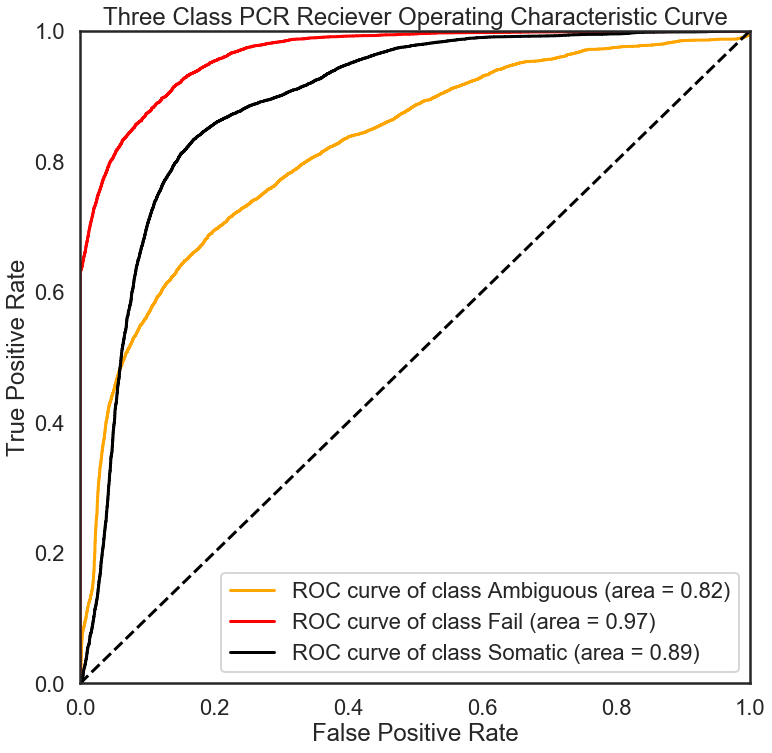

In [43]:
# Plot ROC for the ANN model
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots(figsize=(12,12))
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class PCR Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00143039 0.00274355 0.00381355 0.00514938 0.00536756 0.00570522
 0.00590821 0.00477573 0.00720406 0.00237056]


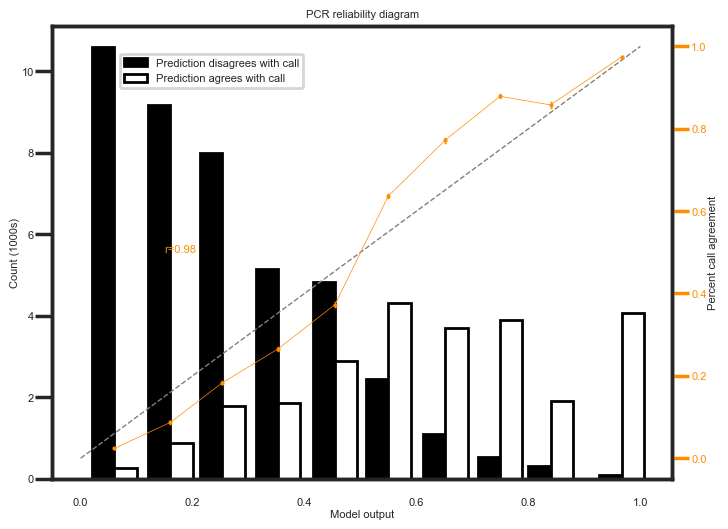

In [44]:
# Plot reliability diagram for PCR
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'PCR reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis

In [45]:
# Rebuild the PCR
model.fit(X_train)
model.x_scores_ = model.transform(X_train)
# get importance by summing the weights for each feature to the first hidden layer
importance = model.explained_variance_ratio_
importances = list(enumerate(importance))
importances.sort(key=lambda x:x[1], reverse = True)
top_n = importances[:5]
print("The 5 most important features for the PCA used in PCR are:")
print()
print("feature                     |  explained variance ")
print("-------------------------------------------")
for counter, entry in enumerate(top_n):
    feature = three_class.columns.drop("call")[counter]
    print(feature, " " * (26-len(feature)), "|      {:.9f}".format(entry[1]))

The 5 most important features for the PCA used in PCR are:

feature                     |  explained variance 
-------------------------------------------
disease_AML                 |      0.232355049
disease_GST                 |      0.212224320
disease_MPNST               |      0.151386164
disease_SCLC                |      0.107724681
disease_breast              |      0.063454445


### Test set performance

In [49]:
# Determine performance on test set
pred = Ridge().fit(model.x_scores_, Y_one_hot)
test_prob = pred.predict(model.transform(X_test))

In [50]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

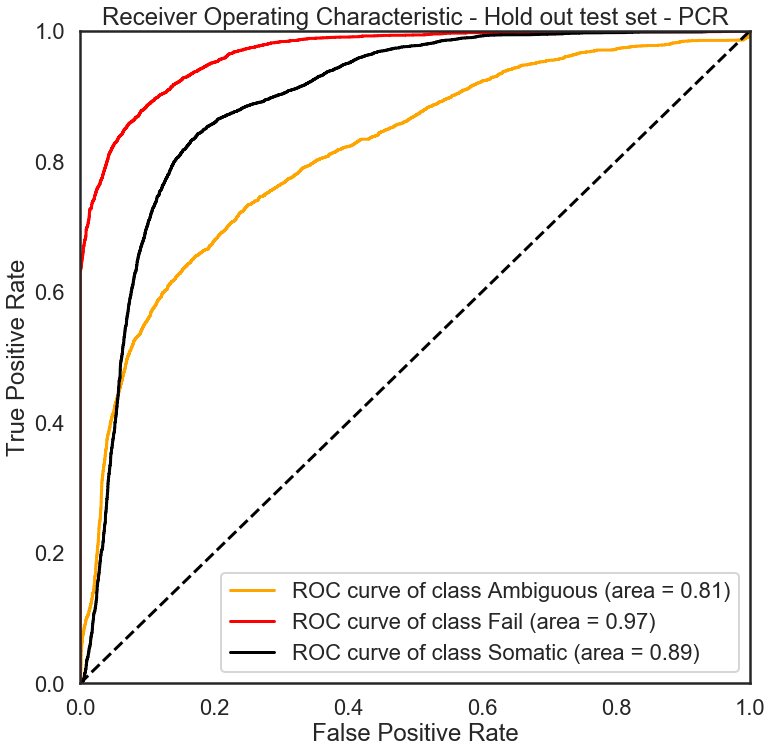

In [51]:
# Plot AUC for test set
fig, ax = plt.subplots(figsize=(12,12))
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'PCR', ax)

confidence intervals +-:  [0.00193391 0.00406088 0.00519453 0.00735199 0.00759747 0.0081369
 0.00848081 0.00675763 0.00995777 0.00305494]


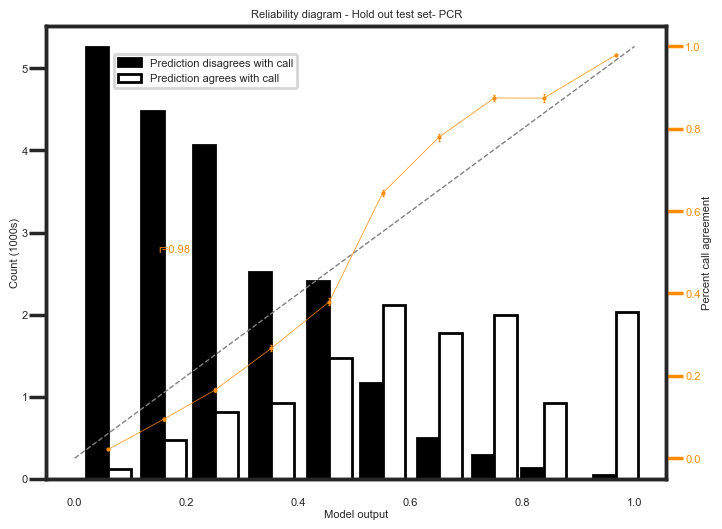

In [52]:
# Plot reliability diagram for test set
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set'
                                 '- PCR',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))